In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score, accuracy_score
import torch 
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from loguru import logger
import matplotlib.pyplot as plt

from nam.config import defaults
from nam.types import Config
from nam.utils.args import parse_args
from nam.data import NAMDataset
from nam.models import DNN, FeatureNN, NAM, get_num_units
from nam.engine import Engine
from nam.utils import graphing

from main import get_config



In [7]:
config = get_config()
config.shallow = True
config.dropout = 0.0
config.activation='relu'
config.n_models = 10
print(config)

Config(activation='relu', batch_size=1024, cross_val=False, data_split=1, dataset_name='Teleco', debug=False, decay_rate=0.995, device='cpu', dropout=0.0, early_stopping_epochs=60, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, learning_rate=0.01, lr=0.01, max_checkpoints_to_keep=1, n_folds=5, n_models=10, num_basis_functions=1000, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=False, save_checkpoint_every_n_epochs=10, seed=1, shallow=True, shuffle=True, training_epochs=10, units_multiplier=2, use_dnn=False)


In [26]:
if False:
    X, y = load_boston(return_X_y=True)
    X.shape, y.shape

    scaler = MinMaxScaler()

    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)

    X_train = torch.from_numpy(X_train.astype('float32'))
    X_test = torch.from_numpy(X_test.astype('float32'))
    y_train = torch.from_numpy(y_train.reshape(-1, 1).astype('float32'))
    y_test = torch.from_numpy(y_test.reshape(-1, 1).astype('float32'))

    dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

elif False:
    housing = pd.read_csv('data/housing.csv')
    housing = housing.drop(['ocean_proximity'],axis=1)
    #housing =(housing-housing.mean())/housing.std()
    #housing = housing.interpolate(method='linear', axis=0)
    print("loaded")
    dataset = NAMDataset(
        config=config,
        csv_file=housing, #'data/GALLUP.csv',
        features_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',],
        targets_column = ['median_house_value'])
else:
    gallup = pd.read_csv('data/GALLUP.csv',nrows=100000)
    gallup = gallup.drop(['country'],axis=1)
    gallup =(gallup-gallup.mean())/gallup.std()
    gallup = gallup.interpolate(method='linear', axis=0)
    dataset = NAMDataset(
        config=config,
        csv_file=gallup,
        features_columns = ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"],
        targets_column = ["WP16"],
        weights_column = ["wgt"],   
        #     one_hot=True,
    )
dataset

train_dataset, test_dataset = torch.utils.data.random_split(
  dataset,
  [int(np.floor(len(dataset) * .9)),
   int(np.ceil(len(dataset) * .1))],
)
print(f"train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}")

train_dataloader = DataLoader(
  train_dataset,
  batch_size=config.batch_size,
  shuffle=True,
  num_workers=config.num_workers,
#   sampler=weighted_sampler,
)

train_dataset: 90000, test_dataset: 10000


In [27]:
batch_size=64

In [28]:
inputs, targets,w = next(iter(train_dataloader))

In [29]:
inputs.shape, targets.shape

(torch.Size([1024, 4]), torch.Size([1024, 1]))

In [30]:
models = []
for n in range(config.n_models):
    models.append(NAM(
        config=config,
        name="NAMModel",
        num_inputs=inputs.shape[1],
        num_units=get_num_units(config, train_dataloader)
    ))

/usr/local/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [31]:
models[3]

NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1000)
        (1): Linear(in_features=1000, out_features=64, bias=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=32, bias=True)
        (4): ReLU()
        (5): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=4)
        (1): Linear(in_features=4, out_features=64, bias=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=32, bias=True)
        (4): ReLU()
        (5): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=26)
        (1): Linear(in_features=26, out_features=64, bias=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=32, bias=True)
        

In [36]:

for model in models:
    loss_obj = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    print("new model")
    for i in range(10):
        optimizer.zero_grad()
        for X, y, *w in train_dataloader:
            y_pred = model(X)
            loss = loss_obj(y_pred, y)
            loss.backward()
            optimizer.step()
        print(loss)

8, in join


  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 138, in join
          File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 138, in join
      File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'    assert self._parent_pid == os.getpid(), 'can only join a child process'assert self._parent_pid == os.getpid(), 'can only join a child process'assert self._parent_pid == os.getpid(), 'can only join a child process'    

assert self._parent_pid == os.getpid(), 'can only join a child process'

AssertionErrorAssertionErrorassert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionErrorAssertionError: AssertionError
: : self._shutdown_workers()se

In [34]:
for model in models:
    y_pred = model(X_test)
    y_test_numpy = y_test.detach().numpy()
    y_pred_numpy = y_pred.detach().numpy()
    print(r2_score(y_test_numpy, y_pred_numpy))

NameError: name 'X_test' is not defined

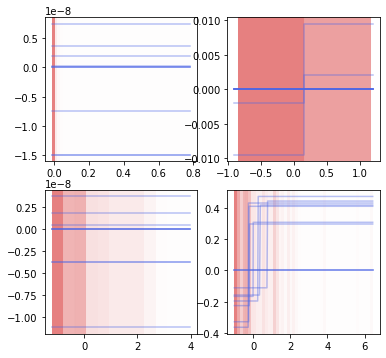

In [37]:
graphing.nam_plot(X,models)